# pvlib-Python Forecasting (Albuquerque, NM)
### Install Standard Release 

In [78]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.0.2)


In [79]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# Downgrade to the prior release 
!pip install cftime==1.0.4.2
# Learned this from Birk
# Website: https://github.com/pvlib/pvlib-python/issues/895

# Try to save Excel
!pip install openpyxl

In [80]:

# # Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=3)
irrad_vars = ['ghi','dni','dhi']

In [81]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [82]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

### Instantiate a GFS model object and get the forecast data from Unidata

In [83]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average  \
2020-04-14 06:00:00-06:00                                              100.0             
2020-04-14 09:00:00-06:00                                                8.0             
2020-04-14 12:00:00-06:00                                                4.0             
2020-04-14 15:00:00-06:00                                                0.0             
2020-04-14 18:00:00-06:00                                                0.0             

                           Wind_speed_gust_surface  \
2020-04-14 06:00:00-06:00                 4.759458   
2020-04-14 09:00:00-06:00                 7.541482   
2020-04-14 12:00:00-06:00                 5.056750   
2020-04-14 15:00:00-06:00                 8.675137   
2020-04-14 18:00:00-06:00                11.497316   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-04-14 06:00:00-06:00                

### Process Data with pvlib

In [84]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-14 06:00:00-06:00   2.888641    3.460732    0.000000    0.000000   
2020-04-14 09:00:00-06:00   0.750031    5.135141  412.211114  612.352449   
2020-04-14 12:00:00-06:00  -1.588379    4.456654  863.070598  712.336495   
2020-04-14 15:00:00-06:00   6.680481    5.928266  812.847329  791.420054   
2020-04-14 18:00:00-06:00  16.156586    9.053285  264.532837  566.237552   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-14 06:00:00-06:00    0.000000         100.0        51.0       100.0   
2020-04-14 09:00:00-06:00  118.044375           8.0         0.0         8.0   
2020-04-14 12:00:00-06:00  242.767291           4.0         0.0         4.0   
2020-04-14 15:00:00-06:00  173.477502           0.0         0.0         0.0   
2020-04-14 18:00:00-06:00   78.315159           0.0         0.0         0.0   

                           high_clouds  
2020-04-14 06:00:00-06:00  

### GFS'S Class

In [85]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-14 06:00:00-06:00   2.888641    3.460732    0.000000    0.000000   
2020-04-14 09:00:00-06:00   0.750031    5.135141  412.211114  612.352449   
2020-04-14 12:00:00-06:00  -1.588379    4.456654  863.070598  712.336495   
2020-04-14 15:00:00-06:00   6.680481    5.928266  812.847329  791.420054   
2020-04-14 18:00:00-06:00  16.156586    9.053285  264.532837  566.237552   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-14 06:00:00-06:00    0.000000         100.0        51.0       100.0   
2020-04-14 09:00:00-06:00  118.044375           8.0         0.0         8.0   
2020-04-14 12:00:00-06:00  242.767291           4.0         0.0         4.0   
2020-04-14 15:00:00-06:00  173.477502           0.0         0.0         0.0   
2020-04-14 18:00:00-06:00   78.315159           0.0         0.0         0.0   

                           high_clouds  
2020-04-14 06:00:00-06:00  

## Cloud Cover & Radiation

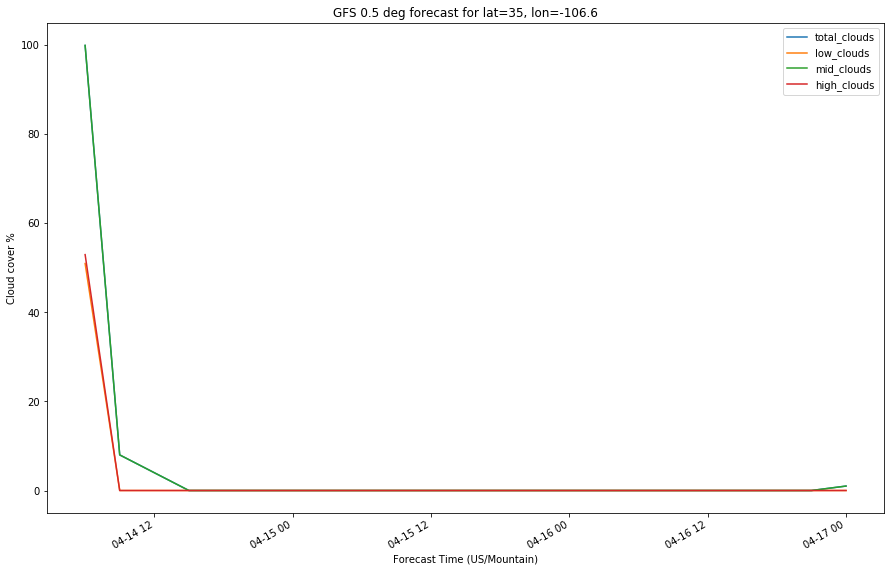

In [86]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

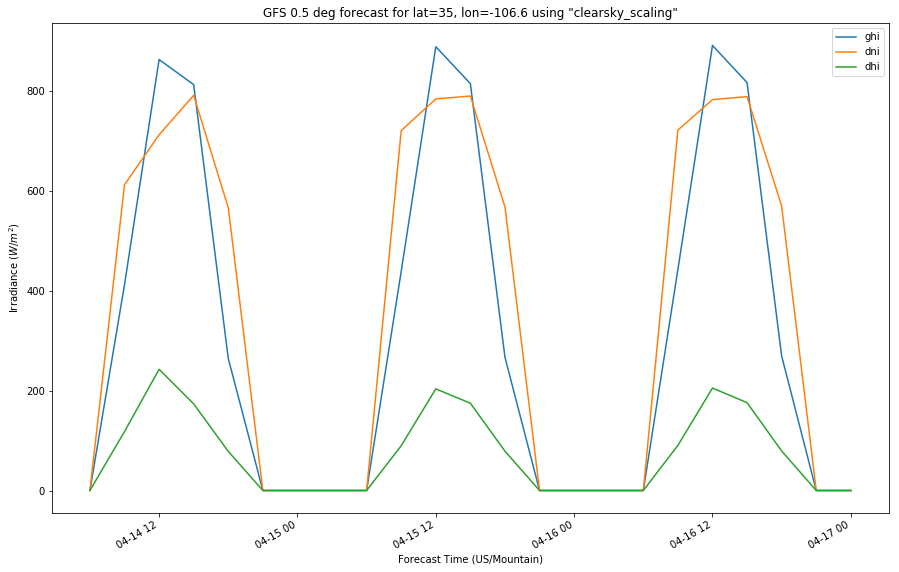

In [87]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

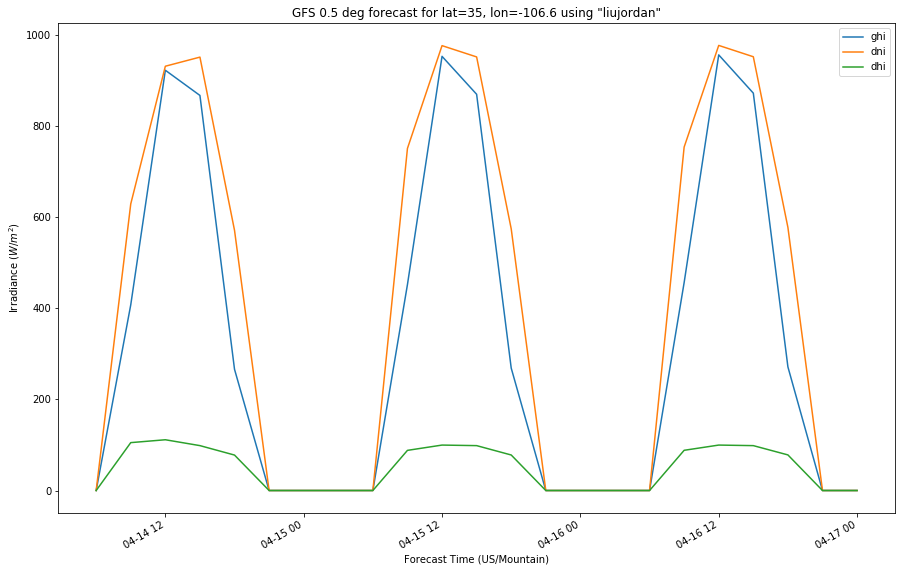

In [88]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

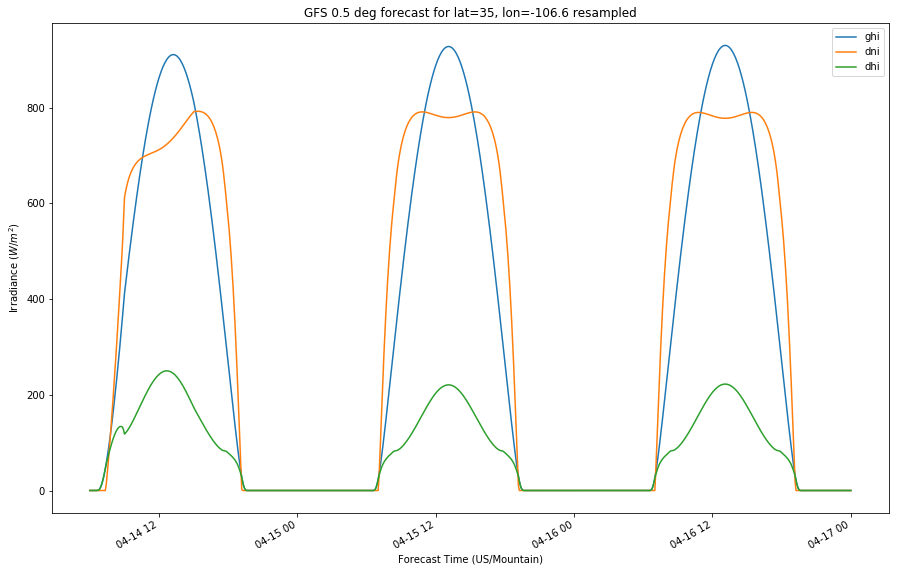

In [89]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

In [90]:
resampled_irrads

,ghi,dni,dhi
2020-04-14 06:00:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:05:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:10:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:15:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:20:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:25:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:30:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:35:00-06:00,0.000000,0.000000,0.000000
2020-04-14 06:40:00-06:00,0.139272,0.000000,0.139272
2020-04-14 06:45:00-06:00,0.915464,0.000000,0.915464


In [91]:
resampled_irrads.to_csv('5 min Irradiance.csv', encoding='utf-8')

## Weather Models
### GFS

In [92]:
# The Global Forecast System is the US model that provides forecast for the entire globe
# It is updated every six hours

### HRRR

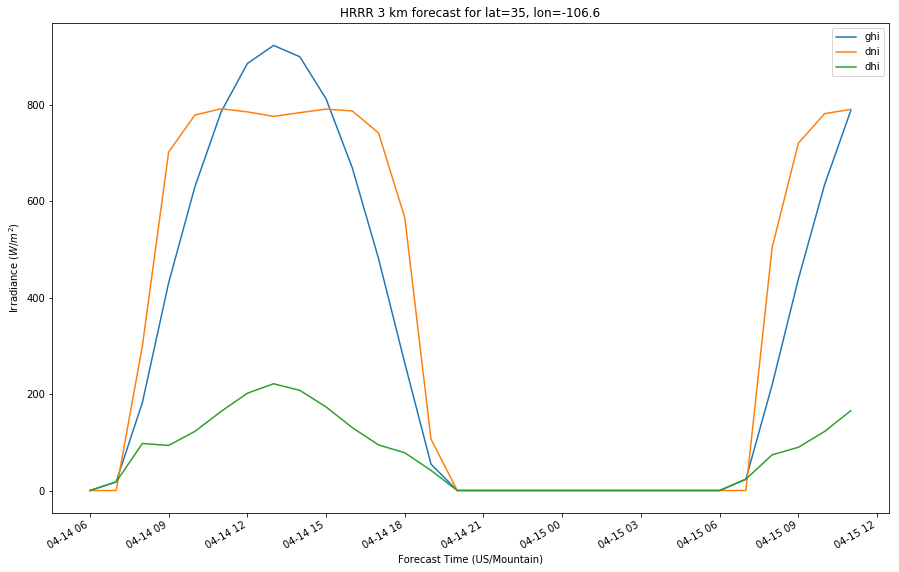

In [93]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

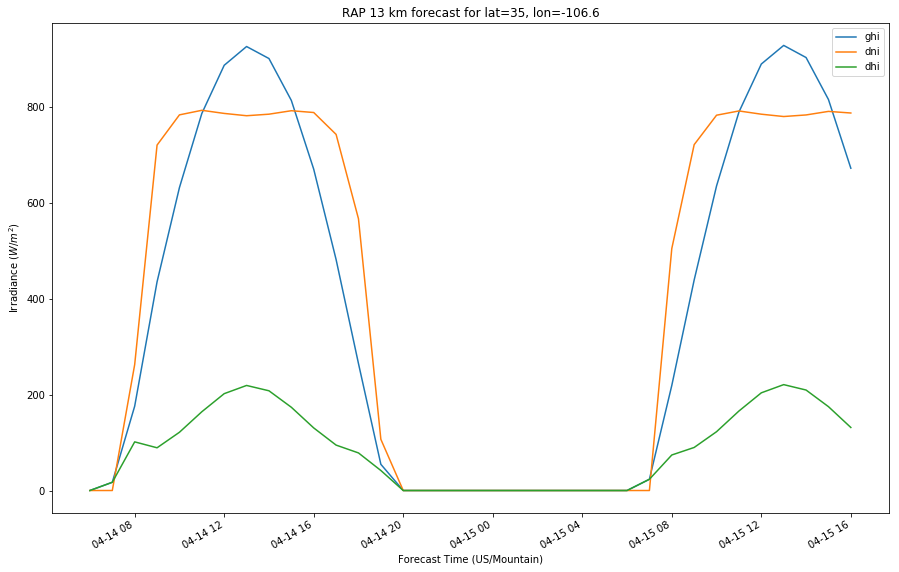

In [94]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

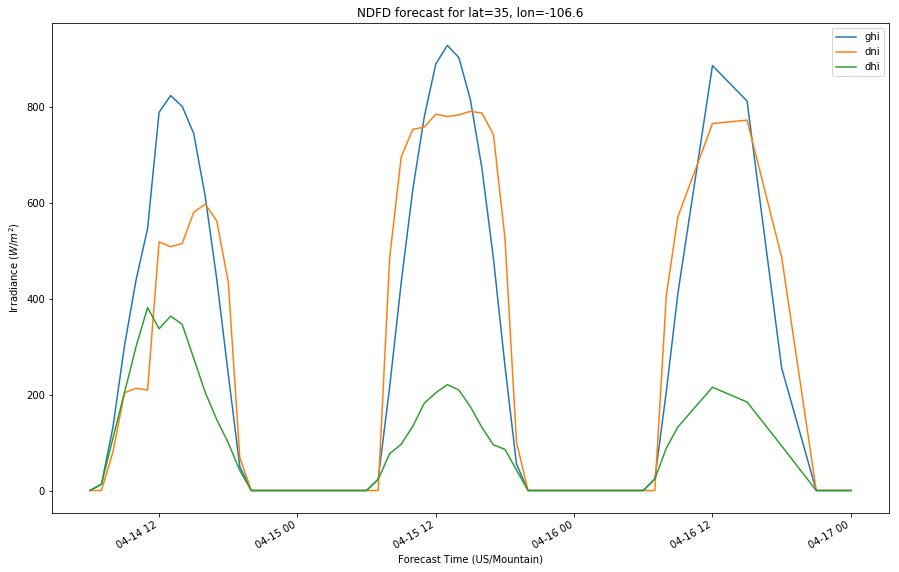

In [95]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

## PV Power Forecast

In [96]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)



ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

### ModelChain Attributes

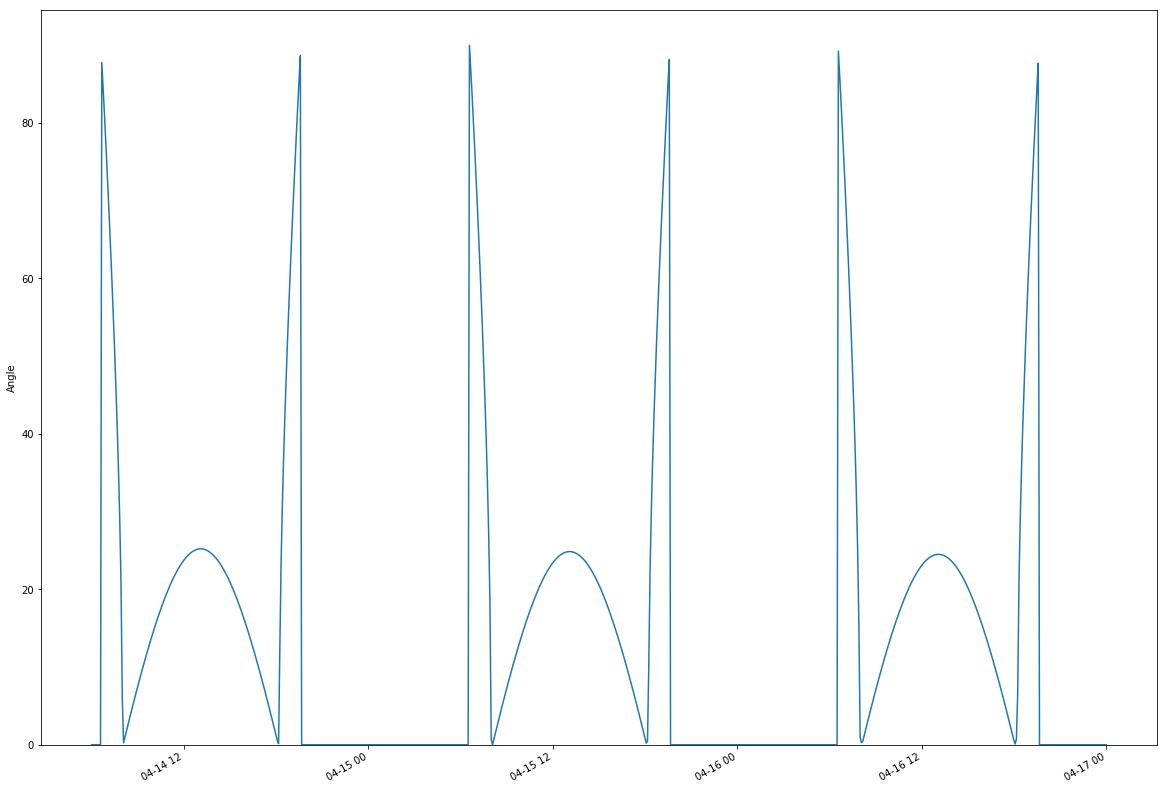

In [97]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

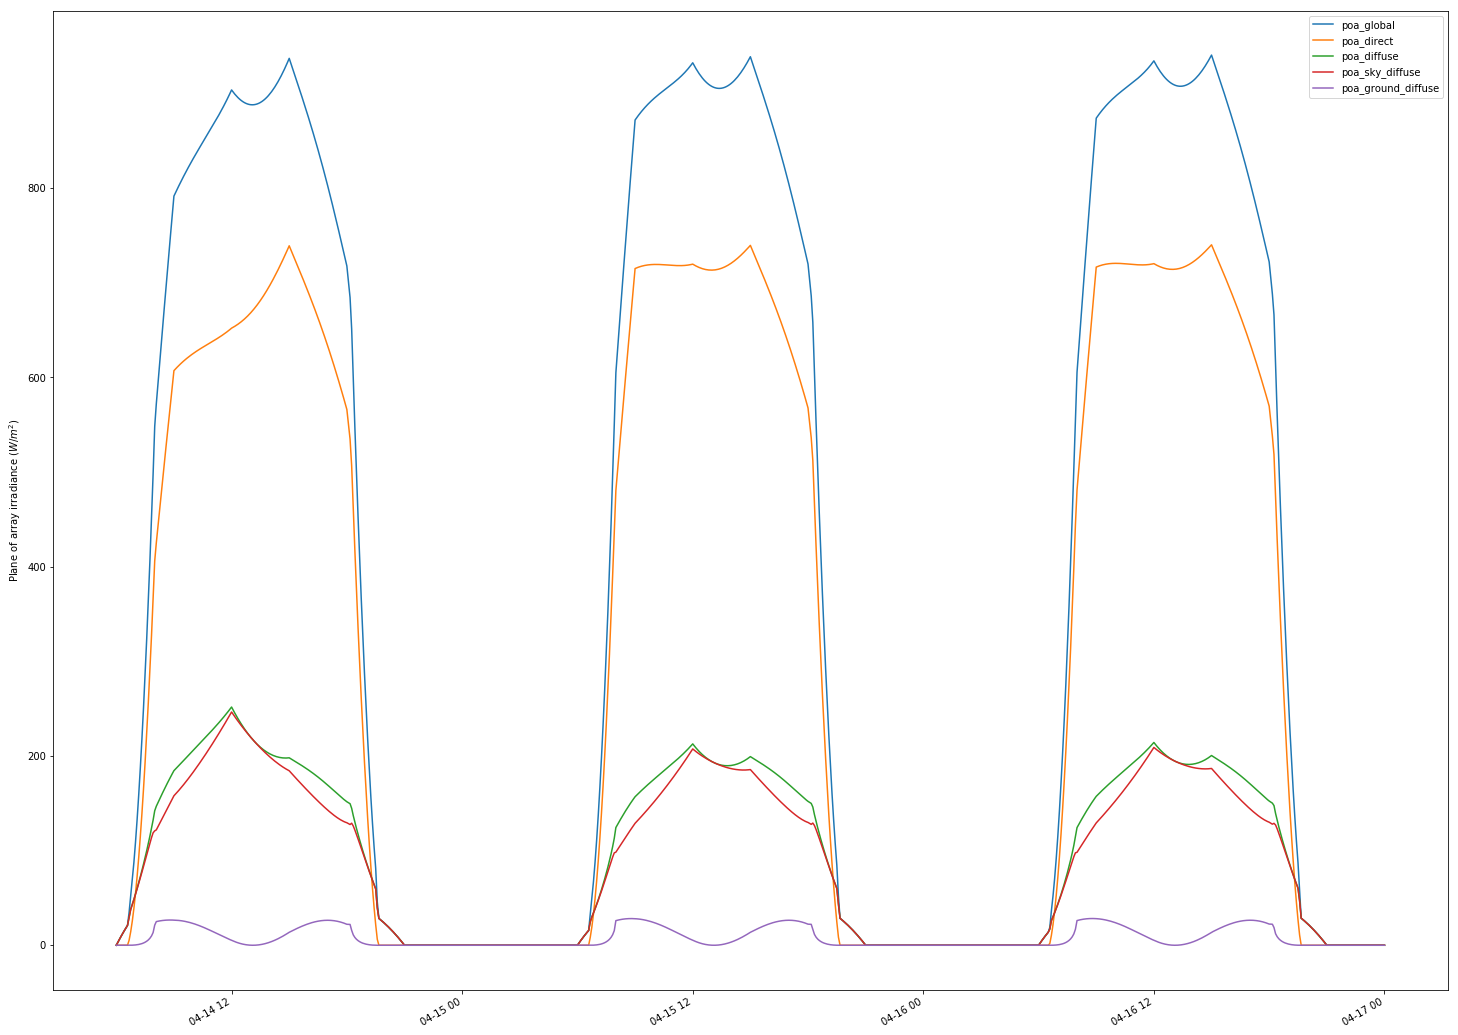

In [98]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

In [99]:
mc.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-04-14 06:00:00-06:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-04-14 06:05:00-06:00,3.237904,0.000000,3.237904,3.237904,0.000000
2020-04-14 06:10:00-06:00,6.393594,0.000000,6.393594,6.393594,0.000000
2020-04-14 06:15:00-06:00,9.467072,0.000000,9.467072,9.467072,0.000000
2020-04-14 06:20:00-06:00,12.458336,0.000000,12.458336,12.458336,0.000000
2020-04-14 06:25:00-06:00,15.367387,0.000000,15.367387,15.367387,0.000000
2020-04-14 06:30:00-06:00,18.194225,0.000000,18.194225,18.194225,0.000000
2020-04-14 06:35:00-06:00,20.938849,0.000000,20.938849,20.938849,0.000000
2020-04-14 06:40:00-06:00,34.683430,5.257469,29.425961,29.421410,0.004551
2020-04-14 06:45:00-06:00,52.091984,14.257285,37.834699,37.805008,0.029691


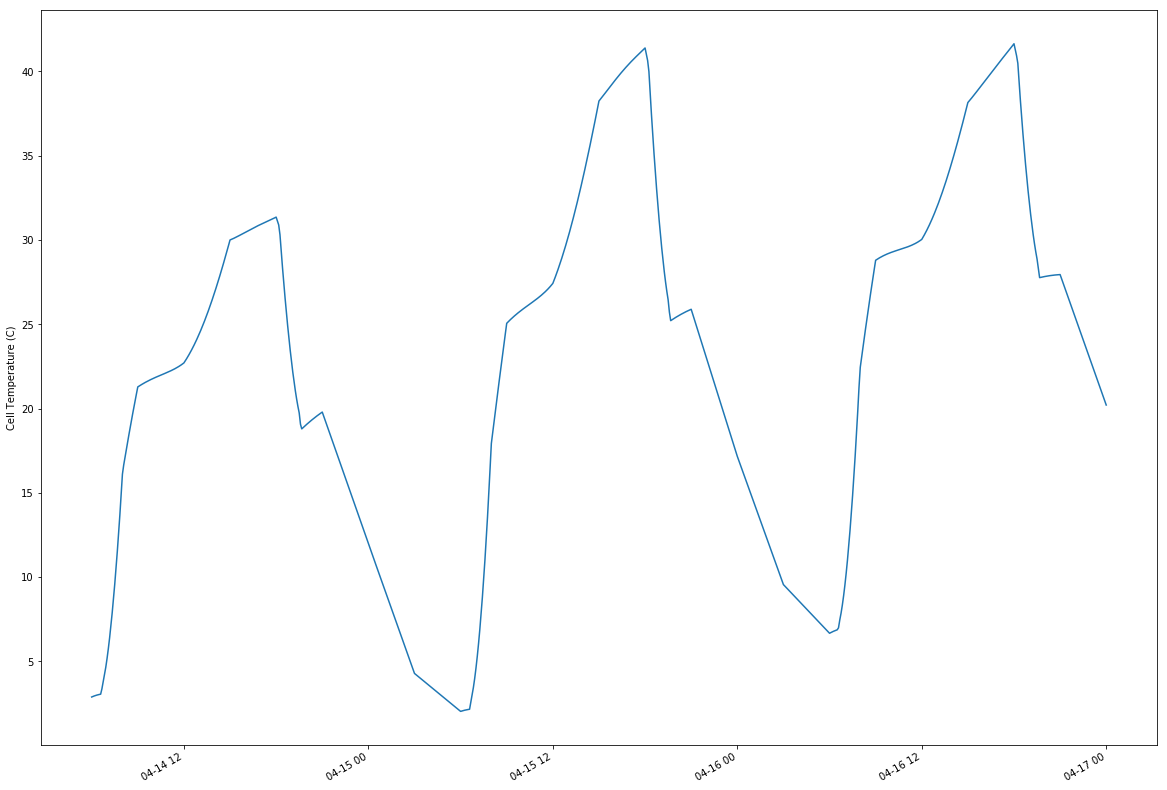

In [100]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

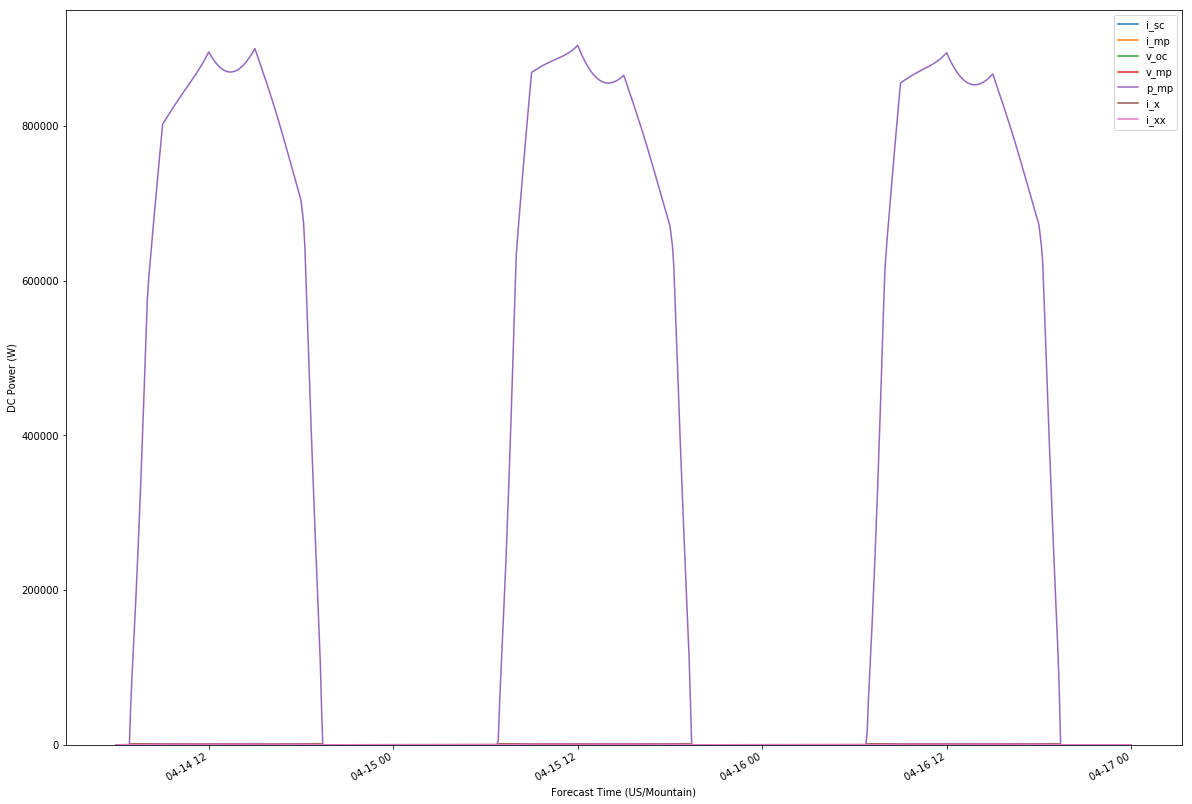

In [101]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

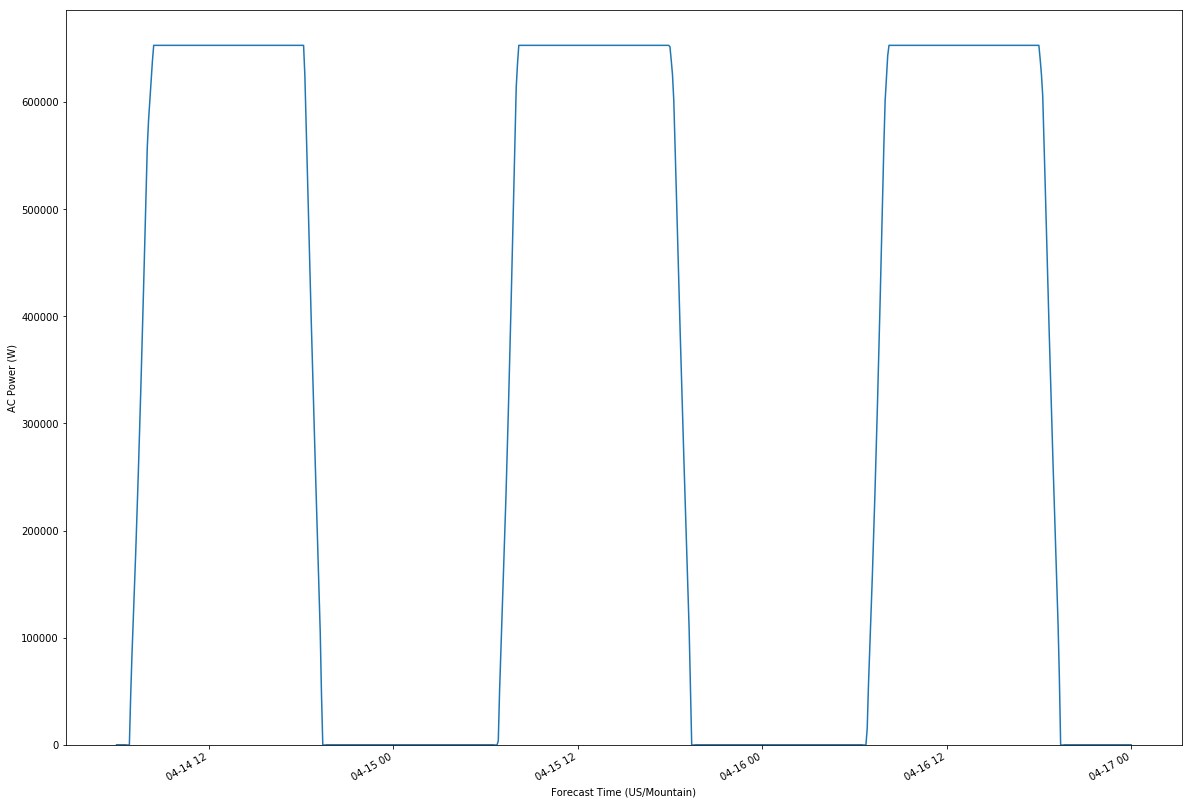

In [102]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [103]:
mc.ac.fillna(0)

2020-04-14 06:00:00-06:00         0.000000
2020-04-14 06:05:00-06:00         0.000000
2020-04-14 06:10:00-06:00         0.000000
2020-04-14 06:15:00-06:00         0.000000
2020-04-14 06:20:00-06:00         0.000000
2020-04-14 06:25:00-06:00         0.000000
2020-04-14 06:30:00-06:00         0.000000
2020-04-14 06:35:00-06:00         0.000000
2020-04-14 06:40:00-06:00      -195.900000
2020-04-14 06:45:00-06:00      -195.900000
2020-04-14 06:50:00-06:00      -195.900000
2020-04-14 06:55:00-06:00     44634.855574
2020-04-14 07:00:00-06:00     82747.197855
2020-04-14 07:05:00-06:00    115029.964077
2020-04-14 07:10:00-06:00    147183.011345
2020-04-14 07:15:00-06:00    180896.917424
2020-04-14 07:20:00-06:00    216528.934080
2020-04-14 07:25:00-06:00    254049.541910
2020-04-14 07:30:00-06:00    293378.435892
2020-04-14 07:35:00-06:00    334485.767526
2020-04-14 07:40:00-06:00    377378.923412
2020-04-14 07:45:00-06:00    421999.650622
2020-04-14 07:50:00-06:00    467992.066798
2020-04-14 

In [104]:
mc.ac.describe()

count       470.000000
mean     564583.502294
std      188994.248920
min        -195.900000
25%      653000.000000
50%      653000.000000
75%      653000.000000
max      653000.000000
dtype: float64

In [65]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')

### Some Errors

In [ ]:
# Cloud cover in percent units
transmittance = ((100.0 - cloud_cover) / 100.0) * 0.75
# Irrads is a DataFrame containing ghi, dni, dhi
irrads = liujordan(apparent_zenith, transmittance, airmass_absolute)

In [ ]:
solpos = Location.get_solarposition(cloud_cover.index)
cs = location.get_clearsky(cloud_cover.index, model='ineichen')
# offset and cloud cover in decimal units here
# larson et. al. use offset = 0.35
ghi = (offset + (1 - offset) * (1 - cloud_cover)) * ghi_clear
dni = disc(ghi, solpos['zenith'], cloud_cover.index)['dni']
dhi = ghi - dni * np.cos(np.radians(solpos['zenith']))